In [ ]:
import tensorflow as tf
msg = tf.constant(f'TensorFlow {tf.__version__} Hello World')
tf.print(msg)

TensorFlow 2.8.0 Hello World


In [ ]:
# just some library to manipulate the data
import numpy as np
import os
import matplotlib.pyplot as plt

# Transfer Learning



## Load the data

You will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True,cache_dir='/content')
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)



68616192/68606236 [==============================] - 1s 0us/step


**Ejercicio**
Reorganiza el dataset ,agrega o quita imagenes para ver que pasa, con un odelo desbalanceado por ejemplo.

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [ ]:
train_dataset.class_names

['cats', 'dogs']

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of batches: %d' % val_batches)

Number of batches: 32


y el dataset de test?

In [ ]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


Revisar la data

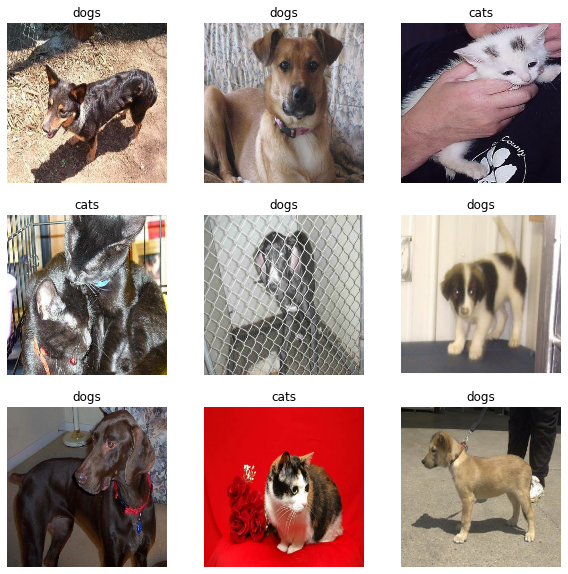

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data aumentation


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.2) )
])

(160, 160, 3)


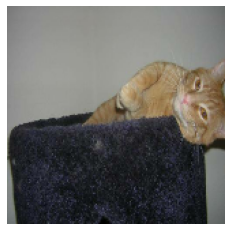

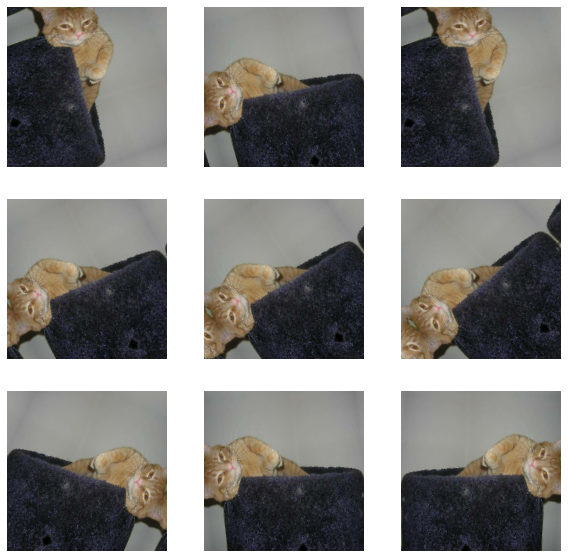

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure()
  first_image = image[0]
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale the pixels

Mobilenet recibe entradas entre -1 y 1 

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Load the Base model

Creará el modelo base a partir del modelo MobileNet V2 desarrollado en Google. Esto se entrena previamente en el conjunto de datos de ImageNet, un gran conjunto de datos que consta de 1,4 millones de imágenes y 1000 clases.  Esta base de conocimientos nos ayudará a clasificar perros y gatos a partir de nuestro conjunto de datos específico.

Primero, debe elegir qué capa de MobileNet V2 para la extracción de características. La última capa de clasificación no es muy útil. En su lugar, la práctica común de depender de la última capa antes de la operación de aplanado. Esta capa se denomina "capa de cuello de botella". Las características de la capa de cuello de botella conservan más generalidad en comparación con la capa final/superior.

Primero, cree una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar el argumento include_top=False , carga una red que no incluye las capas de clasificación en la parte superior, lo que es ideal para la extracción de características.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
print(base_model.summary())
#tf.keras.utils.plot_model(base_model, to_file='model.png')

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

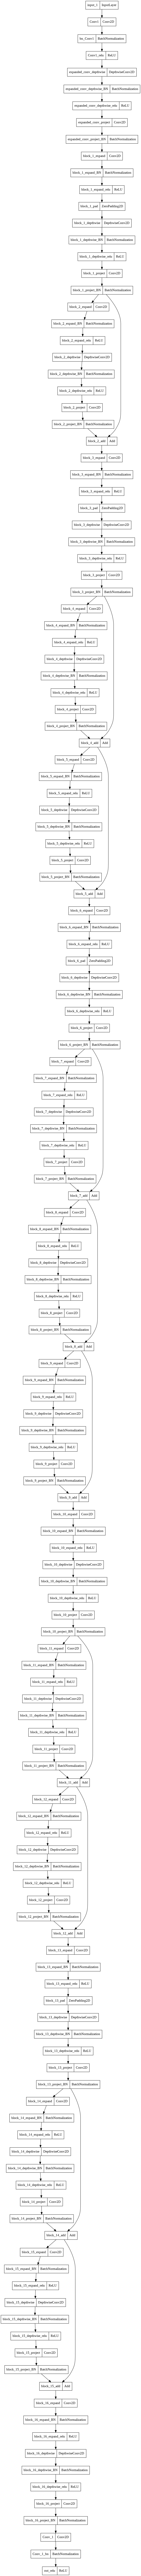

In [ ]:
tf.keras.utils.plot_model(base_model, to_file='model.png')

Este extractor de características convierte cada imagen de 160x160x3 en un bloque de características de 5x5x1280 . Veamos qué le hace a un lote de imágenes de ejemplo:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## New Model

- las capas de preprocesamiento
- las capas del modelo base
- reducir las imagenes 5x5 a un solo 'pixel' con `GlobalAveragePooling2D`
- una capa densa de salida, al ser un clasificador binario solo tentra una neurona




In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Entrenar el modelo

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 4s 45ms/step - loss: 0.9210 - accuracy: 0.4554
initial loss: 0.92
initial accuracy: 0.46


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 67ms/step - loss: 0.7216 - accuracy: 0.5475 - val_loss: 0.6051 - val_accuracy: 0.6213
Epoch 2/10
63/63 [==============================] - 4s 62ms/step - loss: 0.5281 - accuracy: 0.6945 - val_loss: 0.4168 - val_accuracy: 0.7611
Epoch 3/10
63/63 [==============================] - 4s 62ms/step - loss: 0.4094 - accuracy: 0.8010 - val_loss: 0.3257 - val_accuracy: 0.8267
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.3369 - accuracy: 0.8555 - val_loss: 0.2698 - val_accuracy: 0.8577
Epoch 5/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2927 - accuracy: 0.8815 - val_loss: 0.2238 - val_accuracy: 0.8960
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2589 - accuracy: 0.8910 - val_loss: 0.1934 - val_accuracy: 0.9270
Epoch 7/10
63/63 [==============================] - 4s 61ms/step - loss: 0.2439 - accuracy: 0.9020 - val_loss: 0.1760 - val_accuracy: 0.9344
Epoch 8/10
63

Text(0.5, 1.0, 'Training and Validation Accuracy')

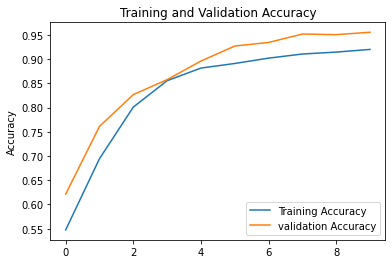

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


In [ ]:
model.save('final_model.h5')

## Sintonización fina

Si deseamos una vez entrenado podemos desactviar el bloqueo de los pesos de las neuronal del modelo Mobilenet. 
Vamos a descongelar algunas capas finales del modelo


In [ ]:
base_model.trainable = True

capas_bloqueadas =len(base_model.layers)- 10
 
for layer in base_model.layers[:capas_bloqueadas]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1)                 1281  

### Train again

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 9s 76ms/step - loss: 0.1684 - accuracy: 0.9260 - val_loss: 0.0737 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 4s 64ms/step - loss: 0.1350 - accuracy: 0.9380 - val_loss: 0.0619 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 4s 63ms/step - loss: 0.1200 - accuracy: 0.9480 - val_loss: 0.0529 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 5s 71ms/step - loss: 0.1039 - accuracy: 0.9570 - val_loss: 0.0530 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 4s 67ms/step - loss: 0.1026 - accuracy: 0.9555 - val_loss: 0.0458 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 7s 105ms/step - loss: 0.0971 - accuracy: 0.9640 - val_loss: 0.0431 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 4s 63ms/step - loss: 0.0905 - accuracy: 0.9590 - val_loss: 0.0473 - val_accuracy: 0.9802
Epoch

Text(0.5, 1.0, 'Training and Validation Accuracy')

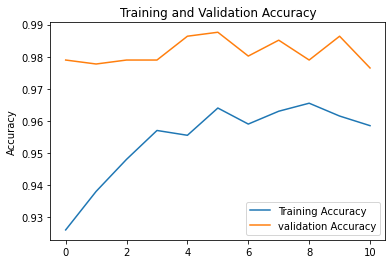

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

In [ ]:
model.save('final_model.h5')

## Test the model


Predictions:
 [0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1]
Labels:
 [0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1]


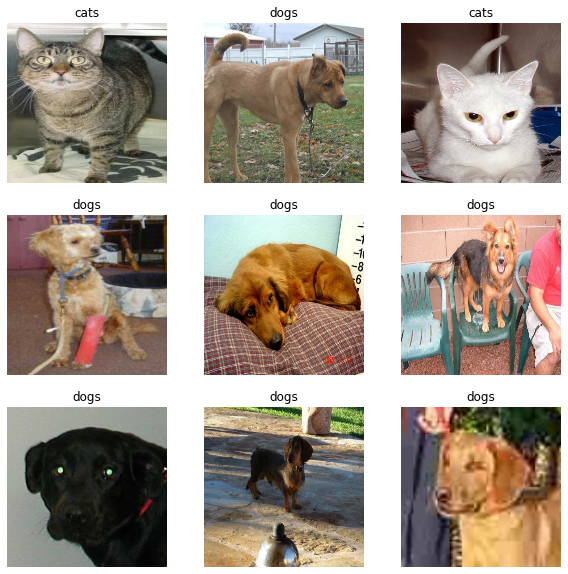

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Deployment


In [ ]:
!pip install gradio

     |████████████████████████████████| 2.9 MB 25.4 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 211 kB 60.1 MB/s 
     |████████████████████████████████| 54 kB 4.0 MB/s 
     |████████████████████████████████| 2.0 MB 68.2 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 253 kB 74.2 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 60.2 MB/s 
     |████████████████████████████████| 144 kB 69.1 MB/s 
     |████████████████████████████████| 10.9 MB 59.8 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 79 kB 11.3 MB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 856 kB 55.2 MB/s 
     |████████████████████████████████| 61 kB 641 kB/s 
     |██████████████████████

In [ ]:

import tensorflow as tf

import gradio as gr

inception_net = tf.keras.models.load_model('final_model.h5')

labels = ['gato','perro']
def classify_image(inp):
    inp = inp.reshape((-1, 160, 160, 3))
    prediction = inception_net.predict(inp).flatten()
    prediction = tf.nn.sigmoid(prediction)
    prediction = tf.where(prediction < 0.5, 0, 1)
    return labels[int(prediction)]

image = gr.inputs.Image(shape=(160, 160), source="upload")
label = gr.outputs.Label()

gr.Interface(
    fn=classify_image, inputs=image, outputs=label, interpretation="default"
).launch(debug=True)

KeyboardInterrupt: ignored

## Ejercicio

Realizar un nuevo clasificador binario, usando mobilenet, para lo cual se recomienda previamente revisar lo que ya tiene preentrenado



In [ ]:
import requests
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")
labels

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

 based in the tensorFlow Sample [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)